In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr

import pandas as pd
import cst
import pyaldata

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = False

In [2]:
filename = '/data/raeed/project-data/smile/cst-gainlag/library/python/Ford_20180618_COCST_TD.mat'
# td = cst.get_cst_dataframe(filename)
td = pyaldata.mat2dataframe(filename,True,'td_cst')
td.set_index('trial_id',inplace=True)

  0%|          | 0/50 [00:00<?, ?it/s]

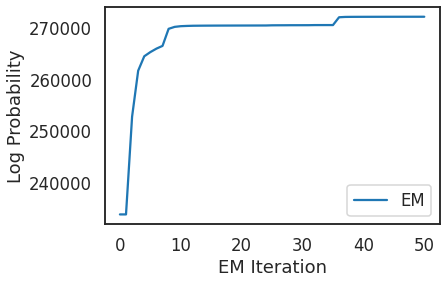

In [6]:
num_states = 3
obs_dim = 1
input_dims = 2
N_iters = 50

lambda_to_use = 3.3
td_lambda = td[td['lambda']==lambda_to_use]
control_obs = [el[:,0][:,None] for el in td_lambda['hand_pos']]
vis_input = [np.column_stack((pos[:,0],vel[:,0]))
            for pos,vel in zip(td_lambda['cursor_pos_shift'],td_lambda['cursor_vel_shift'])]

hmm = ssm.HMM(num_states, obs_dim, M=input_dims, observations="autoregressive",transitions='recurrent_only')

hmm_lls = hmm.fit(control_obs, inputs=vis_input, method="em", num_iters=N_iters, init_method="kmeans") #can also use random for initialization method, which sometimes works better

# make plots
plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [7]:
from ipywidgets import interact

@interact(trial_id=list(td_lambda.index),scale=(10,60),color_by_state=False)
def plot_cst_trial(trial_id,scale,color_by_state):
    trial = td_lambda.loc[trial_id,:]
    
    # Plot the true and inferred discrete states
    hmm_z = hmm.most_likely_states(
        trial['hand_pos'][:,0][:,None],
        input=np.column_stack((trial['cursor_pos'][:,0],trial['cursor_vel'][:,0])),
        )

    plt.figure(figsize=(5,10))
    plt.subplot(211)
    plt.plot([-60,60],[60,-60],'--k')
    plt.plot([0,0],[-60,60],'-k')
    plt.plot([-60,60],[0,0],'-k')
    if color_by_state:
        plt.scatter(trial['cursor_pos'][:,0],trial['hand_pos'][:,0],c=hmm_z,cmap=cmap,s=10)
    else:
        plt.scatter(trial['cursor_pos'][:,0],trial['hand_pos'][:,0],c='k',s=10)
    plt.xlim(-scale,scale)
    plt.ylim(-scale,scale)
    plt.xlabel('Cursor pos')
    plt.ylabel('Hand pos')
    
#     plt.subplot(222)
#     plt.imshow(hmm_z[None,:],
#                aspect="auto",
#                cmap=cmap,
#                vmin=0,
#                vmax=len(colors)-1,
#                extent=(0, trial['bin_size']*trial['hand_pos'].shape[0], -scale, scale))
#     plt.plot(np.arange(0,trial['cursor_pos'].shape[0])*trial['bin_size'],trial['hand_pos'][:,0], '-k')
#     plt.xlim(0, trial['bin_size']*trial['hand_pos'].shape[0])
#     plt.xlabel("time")
#     plt.ylim(-scale,scale)
#     plt.tight_layout()
    
#     plt.subplot(223)
#     plt.imshow(hmm_z[:,None],
#                aspect="auto",
#                cmap=cmap,
#                vmin=0,
#                vmax=len(colors)-1,
#                extent=(-scale, scale, trial['bin_size']*trial['cursor_pos'].shape[0], 0))
#     plt.plot(trial['cursor_pos'][:,0],np.arange(0,trial['cursor_pos'].shape[0])*trial['bin_size'], '-k')
#     plt.ylim(0, trial['bin_size']*trial['hand_pos'].shape[0])
#     plt.ylabel("time")
#     plt.xlim(-scale,scale)
#     plt.tight_layout()
    
    plt.subplot(212)
    plt.plot([0,0],[-100,100],'-k')
    plt.plot([-60,60],[0,0],'-k')
    if color_by_state:
        plt.scatter(trial['cursor_pos_shift'][:,0],trial['cursor_vel_shift'][:,0],c=hmm_z,cmap=cmap,s=10)
    else:
        plt.scatter(trial['cursor_pos_shift'][:,0],trial['cursor_vel_shift'][:,0],c='k',s=10)
    plt.xlim(-scale,scale)
    plt.ylim(-100,100)
    plt.xlabel('Delayed cursor pos')
    plt.ylabel('Delayed cursor vel')

interactive(children=(Dropdown(description='trial_id', options=(151, 152, 153, 154, 155, 158, 159, 160, 161, 1…

In [ ]:
for i in range(num_states):
    plt.subplot(4,2,2*i+2)
    plt.imshow(hmm.observations.As[i],aspect='auto',cmap='RdBu',clim=[-1,1])
    if i==0:
        plt.title('Predicted')
    plt.ylabel('State'+str(i))


In [5]:
print(hmm.observations.As)
print(hmm.observations.bs)
print(hmm.observations.Vs)

[[[1.00750266]]

 [[0.99722153]]

 [[1.00275669]]]
[[ 0.00098821]
 [-0.00173879]
 [-0.00158428]]
[[[ 7.54705811e-03 -2.70763377e-03]]

 [[-2.69224303e-03 -1.24527065e-05]]

 [[ 2.76531724e-03 -1.89999773e-03]]]


In [6]:
print(hmm.transitions.Rs)
print(hmm.transitions.r)
print(hmm.transitions.Ws)

[[ 0.03432678]
 [-0.05791633]
 [ 0.02358955]]
[ 0.98547972 -2.05583098  1.07035126]
[[ 0.04902315 -0.01607239]
 [-0.07762953  0.00866576]
 [ 0.02860638  0.00740663]]


In [ ]:
hmm.transitions.transition_matrices(np.ones((3,1)),input=np.zeros((3,2)),mask=None,tag=None)

In [8]:
for trial_id,trial in td_lambda.iterrows():
    cursor_pos = trial['cursor_pos_shift'][:,0]
    cursor_vel = trial['cursor_vel_shift'][:,0]
    hand_pos = trial['hand_pos'][:,0]
    norm_cursor_pos = np.sqrt(np.mean(cursor_pos**2))
    norm_cursor_vel = np.sqrt(np.mean(cursor_vel**2))
    norm_hand_pos = np.sqrt(np.mean(hand_pos**2))
    print(f"Cursor norm: {norm_cursor_pos}, {norm_cursor_vel}. Hand norm: {norm_hand_pos}")

Cursor norm: 20.424231478312453, 41.19827142401718. Hand norm: 21.480630694019194
Cursor norm: 5.61105745220138, 9.25052322182254. Hand norm: 6.189252648724854
Cursor norm: 6.20130830625251, 27.31931739132772. Hand norm: 7.263373934046816
Cursor norm: 8.507695138878173, 18.49789333908668. Hand norm: 9.866937430683754
Cursor norm: 10.943314875763637, 33.228697579305454. Hand norm: 11.359033035204538
Cursor norm: 7.236795325015762, 25.386132983059724. Hand norm: 9.89081057972995
Cursor norm: 8.749493502473104, 28.15320380681541. Hand norm: 10.310487132527468
Cursor norm: 9.447822843945769, 11.132247100111641. Hand norm: 9.98147240800696
Cursor norm: 33.71513118326782, 29.366167800258886. Hand norm: 32.661696322854894
Cursor norm: 6.093937148788903, 19.927268255616678. Hand norm: 7.449465278408954
Cursor norm: 6.325739991857857, 37.642333506421586. Hand norm: 7.591538350437245
Cursor norm: 8.408214182008955, 18.53500045200462. Hand norm: 9.010981834152133
Cursor norm: 8.013906075794157, 3

In [ ]:
cursor_pos = td.loc[151,'cursor_pos']
cursor_vel = td.loc[151,'cursor_vel']

np.column_stack((cursor_pos[:,1],cursor_vel[:,1]))

In [ ]:
np.unique(td['lambda'])
lambda_to_use = 3.3
td_lambda = td[td['lambda']==lambda_to_use]
control_obs = [el[:,0][:,None] for el in td_lambda['hand_pos']]
vis_input = [np.column_stack((pos[:,0],vel[:,0]))
            for pos,vel in zip(td_lambda['cursor_pos_shift'],td_lambda['cursor_vel_shift'])]
for trial_id,trial in td_lambda.iterrows():
    display(trial)

In [10]:
dir(hmm.observations)

['A',
 'As',
 'D',
 'J0',
 'K',
 'M',
 'Psi0',
 'Sigmas',
 'Sigmas_init',
 'Vs',
 '_As',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compute_mus',
 '_extend_given_sufficient_statistics',
 '_get_sufficient_statistics',
 '_sqrt_Sigmas',
 '_sqrt_Sigmas_init',
 'b',
 'bs',
 'h0',
 'initialize',
 'l2_penalty_A',
 'l2_penalty_V',
 'l2_penalty_b',
 'lags',
 'log_likelihoods',
 'log_prior',
 'm_step',
 'mu_init',
 'neg_hessian_expected_log_dynamics_prob',
 'nu0',
 'params',
 'permute',
 'sample_x',
 'smooth']